Overleaf doc: https://www.overleaf.com/read/ysgbfhgmndrs

This notebook requires:
- jaxlib (`pip install jaxlib`)
- jax
- sympy
- scipy
- sympy2jax (`pip install sympy2jax`) -- but sympy's built-in lambdify should be sufficient for our uses

Not needed but in case we want to parse LaTeX:

- antlr4 python runtime (`conda install -c conda-forge antlr-python-runtime`) — for sympy's LaTeX parsing

In [1]:
import jax
import jax.numpy as jnp
import sympy
# from sympy.parsing.latex import parse_latex
# from sympy2jax import sympy2jax
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const

In [3]:
%matplotlib notebook

---

### jax testing

In [4]:
def func(x):
    return jnp.sin(x) ** 2
def pot(x):
    return x ** 2

In [5]:
func_grad = jax.grad(func)

<IPython.core.display.Javascript object>


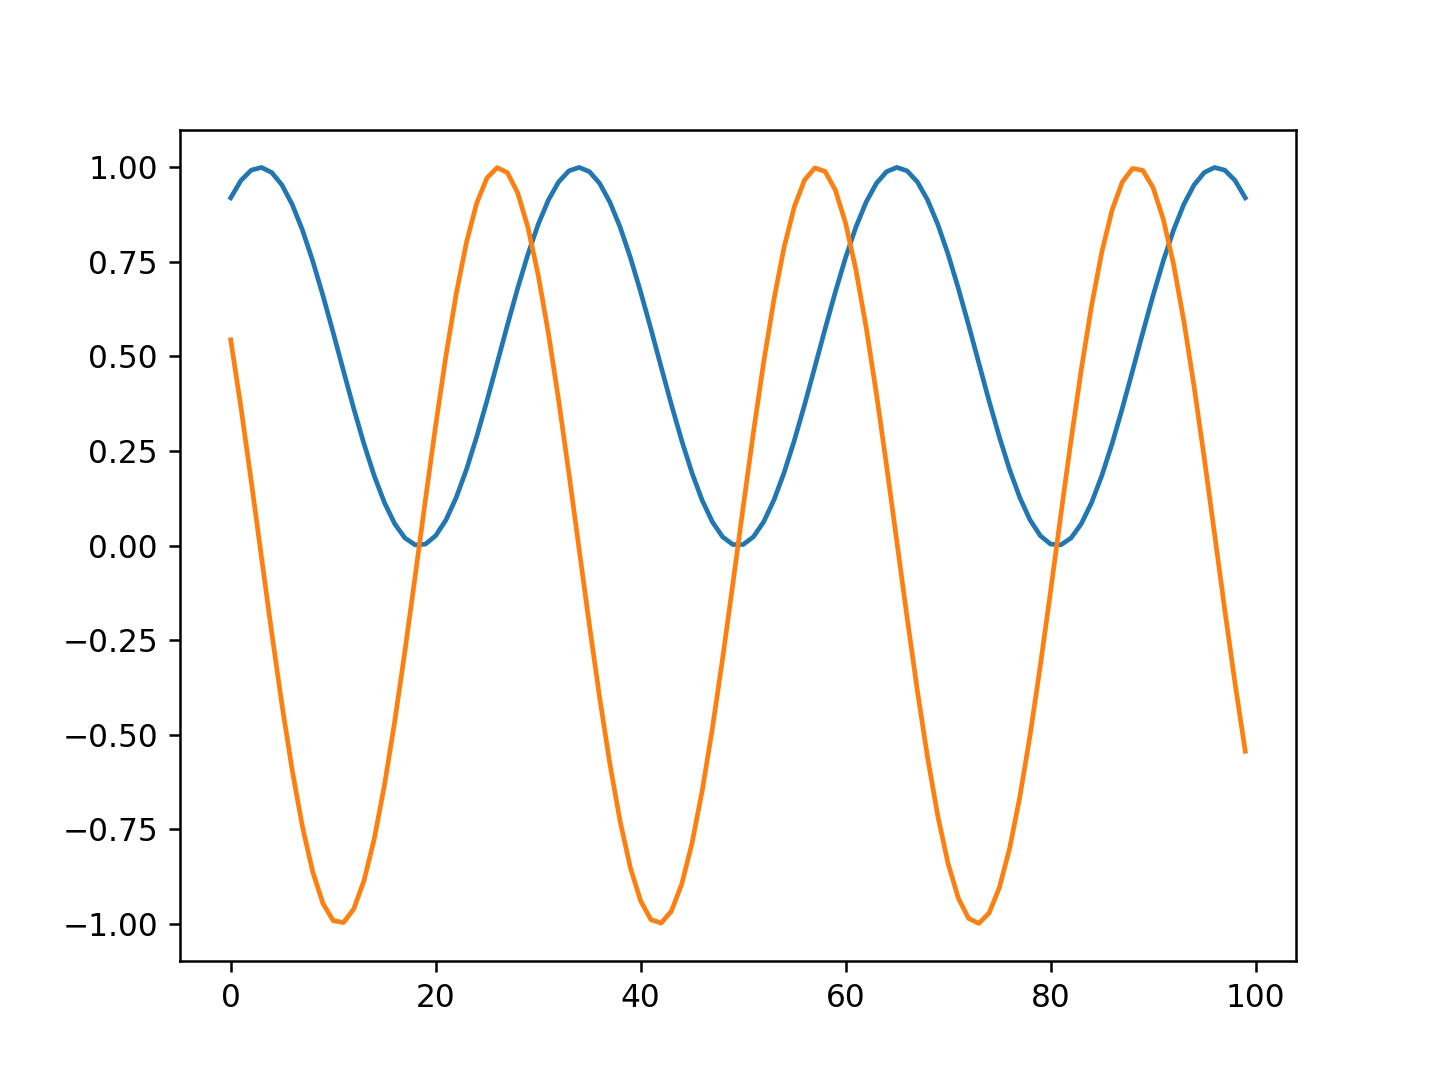

In [6]:
plt.figure()
plt.plot(func(jnp.linspace(-5, 5, 100)))
# Need jax.vmap to vectorize the function
plt.plot(jax.vmap(func_grad)(jnp.linspace(-5, 5, 100)))

---

### sympy testing

In [3]:
E_b, R_p, beta = sympy.symbols('E_{b} R_{p} beta')

In [48]:
equation = parse_latex(r"0.089 E_b \log \left(\frac{R_p}{1-\beta} \right)^{0.4}")

In [51]:
equation.as_terms()

([(0.089*(E_{b}*log(R_{p}/(1 - beta), 10)**0.4), ((0.089, 0.0), (1, 1), ()))],
 [E_{b}, log(R_{p}/(1 - beta), 10)**0.4])

In [6]:
equation.free_symbols

{E_{b}, R_{p}, beta}

In [7]:
equation.subs({'E_{b}': 1.0,
               'R_{p}': 1.0,
               'beta': 0.5})

0.0768635061536114

In [36]:
from sympy.abc import x
from sympy import log

In [37]:
# x = sympy.symbols('x')
f = sympy.lambdify(x, log(x))

In [54]:
expr = parse_latex(r"\log(x)")

In [55]:
expr.as_terms()

([(log(x, 10), ((1.0, 0.0), (1,), ()))], [log(x, 10)])

In [57]:
f = sympy.lambdify(x, expr)

In [15]:
import math

In [24]:
f = sympy.lambdify((E_b, R_p, beta), equation, modules=[{'log': math.log}, jnp])

In [28]:
f(jnp.ones(1), jnp.ones(1), jnp.zeros(1))

DeviceArray([0.], dtype=float32)

In [124]:
p1, p2 = sympy.symbols("m p")
eq = parse_latex(r"\frac{m}{p}")

In [125]:
mod = sympy2jax.SymbolicModule(eq)

In [126]:
mod(p1=1.0, p2=0.5)

KeyError: 'Missing input for symbol m'

In [68]:
[a, b] = sympy.symbols('a_d b_d')

In [70]:
asdf = a/b

# Fundamental parameters

I'm filling out the parameters as I go along

In [147]:
# Machine / engineering parameters
[Eb,
 Rp,
 beta,
 B_m,
 B_p,
 r_b,
 L_p,
] = sympy.symbols('Eb '
                  'Rp '
                  'beta '
                  'B_m '
                  'B_p '
                  'r_b '
                  'L_p ')

# Physics parameters?
[mu,
 E_i,
 Z_eff,
 I_cooling,
 sigmav_DT,
 sigmav_DD,
 tau_alpha
] = sympy.symbols('mu '
                  'E_i '
                  'Z_eff '
                  'I_cooling '
                  'sigmav_DT '
                  'sigmav_DD '
                  'tau_alpha')

# Constants

In [148]:
E_alpha = 3.5  # MeV

# General formulae

Ion temperature

In [90]:
Ti = 2/3 * Eb

# Derived quantities

Electron temperature 
$T_e = 0.089 E_b \log \left( R_p \right)^{0.4} = 0.089 E_b \log \left(\frac{R_p}{1-\beta} \right)^{0.4}$

In [80]:
Te = 0.089 * Eb * (sympy.log(Rp / (1 - beta)) ** 0.4); Te

0.089*Eb*log(Rp/(1 - beta))**0.4

## End cells / plugs

Mirror ratio $R_{\text{plug}} = \frac{B_m}{B_p}$

In [81]:
R_plug = B_m / B_p; R_plug

B_m/B_p

Radius at midplane $a_{\text{plug}} = r_b \sqrt{\frac{B_m}{B_p}} = r_b \sqrt{R_{plug}}$

In [82]:
a_plug = r_b * sympy.sqrt(R_plug); a_plug

r_b*sqrt(B_m/B_p)

Volume $V_p = L_p \pi a_p^2$

In [84]:
V_p = L_p * sympy.pi * a_plug ** 2; V_p

pi*B_m*L_p*r_b**2/B_p

Density at a given beta: $n_{\text{plug}} = B_p^2 \frac{\beta_{\text{limit}}}{2\mu_0 |e|\left(T_{\text{ion}} + T_e \right)}$

In [91]:
n_plug = B_p ** 2 * beta / (2 * const.mu_0 * const.e * (Ti + Te))

Total particle number: $N_{\text{tot}} = V_p n_{\text{plug}}$

In [92]:
N_tot = V_p * n_plug; N_tot

pi*B_m*B_p*L_p*beta*r_b**2/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)

**General formula:** Particle conefinement time $\tau_{\text{Fowler/Baldwin}} = 2.8 \cdot 10^{12} \frac{E_b^{3/2}}{n_e} \log R_m$

In [94]:
tau_Fowler_Baldwin = 2.8 * 10 ** 12 * Eb ** (3/2) / n_plug * sympy.log(Rp); tau_Fowler_Baldwin

2800000000000.0*Eb**1.5*(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)*log(Rp)/(B_p**2*beta)

Particles lost per second: $\frac{dN}{dt} = \frac{N_{\text{tot}}}{\tau_{\text{Fowler/Baldwin}}}$

In [95]:
dN_dt = N_tot / tau_Fowler_Baldwin; dN_dt

3.57142857142857e-13*pi*B_m*B_p**3*L_p*beta**2*r_b**2*(1.38765661654981e+49/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2)/(Eb**1.5*log(Rp))

**General formula:** Ion gyroradius at center of the plug: $\rho_i = \frac{m v_\perp}{q B} = 3.22\cdot 10^{-3} \frac{\sqrt{\mu E_{\text{ion}}}}{B_p}$

In [102]:
rho_i = 3.22 * 10 ** -3 * sympy.sqrt(mu * E_i) / B_p; rho_i

0.00322*sqrt(E_i*mu)/B_p

Number of gryoradii in the plasma radius: $N_{\text{gyro}} = \frac{a_p}{\rho_i}$

In [103]:
N_gyro = a_plug / rho_i; N_gyro

310.55900621118*B_p*r_b*sqrt(B_m/B_p)/sqrt(E_i*mu)

NBI current (A): $I_{\text{NBI}}=|e|\frac{dN}{dt}$

In [104]:
I_NBI = const.elementary_charge * dN_dt; I_NBI

7.94025359661286e+17*pi*B_m*B_p**3*L_p*beta**2*r_b**2/(Eb**1.5*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp))

**General formula:** Coulomb logarithms: $\lambda_{ei} = 24 - 0.5\ln{n_e} + \ln{T_e}$

In [105]:
lambda_ei = 24 - 0.5 * sympy.log(n_plug) + sympy.log(Te); lambda_ei

log(0.089*Eb*log(Rp/(1 - beta))**0.4) - 0.5*log(B_p**2*beta/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)) + 24

**General formula:** Slowing down times: $\tau_{i,\text{slow}} = 0.1 \frac{\mu T_e^{3/2}}{n_{20} Z^2 \lambda_{ei}}$

In [122]:
tau_i_slow = 0.1 * mu * Te ** (3/2) / (n_plug / 10 ** 20 * Z_eff ** 2 * lambda_ei); tau_i_slow

2.65512523245138e+17*mu*(Eb*log(Rp/(1 - beta))**0.4)**1.5*(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)/(B_p**2*Z_eff**2*beta*(log(0.089*Eb*log(Rp/(1 - beta))**0.4) - 0.5*log(B_p**2*beta/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)) + 24))

Electron heating by fast ions (MW): $10^{-3}\frac{I_{\text{NBI}}E_b}{\tau_{\text{slow}}}$

In [133]:
P_e_heating_fastI = 10 ** -3 * I_NBI * Eb / tau_i_slow; P_e_heating_fastI

0.00299053826145967*pi*B_m*B_p**5*L_p*Z_eff**2*beta**3*r_b**2*(log(0.089*Eb*log(Rp/(1 - beta))**0.4) - 0.5*log(B_p**2*beta/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)) + 24)/(Eb**0.5*mu*(Eb*log(Rp/(1 - beta))**0.4)**1.5*(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp))

**General formula:** Lorentz factor: $\gamma = \sqrt{1 - \frac{T_e}{m_e c^2}} = \sqrt{1 - \frac{T_e}{511 \text{keV}}}$

In [124]:
gamma = sympy.sqrt(1 - Te / 511); gamma

sqrt(-0.000174168297455969*Eb*log(Rp/(1 - beta))**0.4 + 1)

Synchrotron radiation power loss (MW): $ P_{\text{synch}} = 6\cdot10^{-3} V_p n_{20} T_e \gamma^2 B_p^2$

In [125]:
P_synch = 6 * 10 ** -3 * V_p * n_plug / 10 ** 20 * Te * gamma ** 2 * B_p ** 2; P_synch

5.34e-24*pi*B_m*B_p**3*Eb*L_p*beta*r_b**2*(-0.000174168297455969*Eb*log(Rp/(1 - beta))**0.4 + 1)*log(Rp/(1 - beta))**0.4/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)

Bremsstrahlung radiation power loss (MW): $P_{\text{brem}} = 5.35\cdot10^{-3} n_{20}^2 Z_{\text{eff}}\sqrt{T_e} V_p$

In [127]:
P_brem = 5.35 * 10 ** -3 * (n_plug / 10 ** 20) ** 2 * Z_eff * sympy.sqrt(Te) * V_p; P_brem

2214781.03558431*pi*B_m*B_p**3*L_p*Z_eff*beta**2*r_b**2*sqrt(Eb*log(Rp/(1 - beta))**0.4)/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2

Power loss from escaping electrons (MW): $P_{\text{e,endloss}} = 10^{-3}(I_{\text{NBI}}+I_{\text{cooling}})\cdot 7 T_e$

In [129]:
P_e_endloss = 10 ** -3 * (I_NBI + I_cooling) * 7 * Te; P_e_endloss

0.089*Eb*(5.55817751762901e+15*pi*B_m*B_p**3*L_p*beta**2*r_b**2/(Eb**1.5*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp)) + 0.007*I_cooling)*log(Rp/(1 - beta))**0.4

Power loss from escaping fast ions (MW): $P_{\text{i,endloss}} = 10^{-3} I_{\text{NBI}} \left(E_b-T_e\right)$

In [131]:
P_i_endloss = 10 ** -3 * I_NBI * (Eb - Te); P_i_endloss

794025359661286.0*pi*B_m*B_p**3*L_p*beta**2*r_b**2*(-0.089*Eb*log(Rp/(1 - beta))**0.4 + Eb)/(Eb**1.5*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp))

Injected NBI Power (MW): $P_{\text{NBI}} = 10^{-3}I_{\text{NBI}} E_b$

In [132]:
P_NBI = 10 ** -3 * I_NBI * Eb; P_NBI

794025359661286.0*pi*B_m*B_p**3*L_p*beta**2*r_b**2/(Eb**0.5*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp))

Injected ECH Power (MW): $P_{\text{ECH}} = \frac{P_{\text{synch}}}{20} +P_{\text{e,endloss}} - \left(\text{Electron heating from fast ions}\right)$

In [135]:
P_ECH = P_synch / 20 + P_e_endloss - P_e_heating_fastI; P_ECH

-0.00299053826145967*pi*B_m*B_p**5*L_p*Z_eff**2*beta**3*r_b**2*(log(0.089*Eb*log(Rp/(1 - beta))**0.4) - 0.5*log(B_p**2*beta/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)) + 24)/(Eb**0.5*mu*(Eb*log(Rp/(1 - beta))**0.4)**1.5*(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb)*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp)) + 2.67e-25*pi*B_m*B_p**3*Eb*L_p*beta*r_b**2*(-0.000174168297455969*Eb*log(Rp/(1 - beta))**0.4 + 1)*log(Rp/(1 - beta))**0.4/(3.58377107825779e-26*Eb*log(Rp/(1 - beta))**0.4 + 2.68447271779609e-25*Eb) + 0.089*Eb*(5.55817751762901e+15*pi*B_m*B_p**3*L_p*beta**2*r_b**2/(Eb**1.5*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2*log(Rp)) + 0.007*I_cooling)*log(Rp/(1 - beta))**0.4

DT fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DT}}=V_p \frac{n_{\text{plug}}^2}{4} \langle\sigma v\rangle_{DT}$

In [138]:
Rx_plug_DT = V_p * n_plug ** 2 / 4 * sigmav_DT; Rx_plug_DT

3.46914154137452e+48*pi*B_m*B_p**3*L_p*beta**2*r_b**2*sigmav_DT/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2

DD fusion reaction rate (#/s). Here we assume a 50-50 DT fuel mixture: $R_{\text{x,plug,DD}}=V_p n_{\text{plug}}^2 \langle\sigma v\rangle_{DD}$

In [139]:
Rx_plug_DD = V_p * n_plug ** 2 * sigmav_DD; Rx_plug_DD

1.38765661654981e+49*pi*B_m*B_p**3*L_p*beta**2*r_b**2*sigmav_DD/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2

Fusion power (MW): $P_{\text{plug}}=17.6|e|R_{\text{x,plug}}$ -- we're just focusing on DT for now. Including DD it'd be: $P_{\text{plug}}=17.6|e|R_{\text{x,plug,DT}} + \frac{4.03+3.27}{2}|e|R_{\text{x,plug,DD}}$

In [140]:
P_fus_plug = 17.6 * const.elementary_charge * Rx_plug_DT; P_fus_plug

9.78239243102705e+30*pi*B_m*B_p**3*L_p*beta**2*r_b**2*sigmav_DT/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2

Lawson Triple Product ($10^{20}$keV$\cdot$s/m$^3$): $\tau_{\text{Fowler/Baldwin}} n_{20} T_i$

In [142]:
triple_product = tau_Fowler_Baldwin * n_plug / 10 ** 20 * Ti; triple_product

1.86666666666667e-8*Eb**2.5*log(Rp)

Neutron Flux, DT only (MW/m$^2$): $\frac{14}{17.6}\frac{P_{\text{plug}}}{4\pi a_{\text{wall}}^2}$

In [143]:
neutron_flux = 14 / 17.6 * P_fus_plug / (4 * const.pi * a_plug ** 2); neutron_flux

6.19227998559027e+29*pi*B_p**4*L_p*beta**2*sigmav_DT/(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2

Burnup fraction, DT: $\frac{R_{\text{x,plug,DT}}}{dN/dt}$

In [144]:
frac_burnup = Rx_plug_DT / dN_dt; frac_burnup

700000000000.0*Eb**1.5*sigmav_DT*log(Rp)

$Q_{\text{plug}}$: $Q_{\text{plug}} = \frac{P_{\text{plug}}}{P_{\text{injected}}}$

In [146]:
Q_plug = P_fus_plug / P_NBI; Q_plug

1.232e+16*Eb**0.5*sigmav_DT*log(Rp)

$\alpha$ particle density ($10^{20}m^{-3}$): $n_{\alpha} = \frac{I_{\text{NBI}} Q_{\text{plug}} \tau_{\alpha} E_b}{16 V_p E_{\alpha}}$

In [150]:
n_alpha = I_NBI * Q_plug * tau_alpha * E_b / (16 * V_p * E_alpha); n_alpha

1.74685579125483e+32*B_p**4*E_{b}*beta**2*sigmav_DT*tau_alpha/(Eb**1.0*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2)

$Z_{\text{eff}}$: $Z_{\text{eff}} = 1 +2n_{\alpha}$

In [151]:
Z_eff = 1 + 2 * n_alpha; Z_eff

3.49371158250966e+32*B_p**4*E_{b}*beta**2*sigmav_DT*tau_alpha/(Eb**1.0*(0.1335*Eb*log(Rp/(1 - beta))**0.4 + Eb)**2) + 1

In [152]:
Q_plug.free_symbols

{Eb, Rp, sigmav_DT}